In [15]:
%reset -sf

from time import time
time_start = time()

import pandas as pd
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt

import gc
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' # suppress tensorflow imformation messages

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf

from xgboost import XGBRegressor
from xgbtune.tune import tune_xgb_model

import get_data as gd
import atlas_plot as ap
plot = ap.Plotter()

print(tf.__version__)
print(tf.config.list_physical_devices())
print()

2.13.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]



In [16]:
seed = 42  # set random seed
sampling = int(1e5)
num_folds = 3

In [17]:
np.random.seed(seed)
processor = gd.DataProcessor(sampling=sampling, processor=10)
path = "/root/data/truth/signal/*npz"
processor.load_files(path)
data = gd.Data(*processor.files)
# print(dir(data))

Number of available processors: 128
Number of used processors: 10

['/root/data/truth/signal/CGLMP.npz', '/root/data/truth/signal/Higgs.npz', '/root/data/truth/signal/LeadLepton.npz', '/root/data/truth/signal/LeptonM.npz', '/root/data/truth/signal/LeptonP.npz', '/root/data/truth/signal/LmNu.npz', '/root/data/truth/signal/LpNu.npz', '/root/data/truth/signal/MET.npz', '/root/data/truth/signal/WmBoson.npz', '/root/data/truth/signal/WpBoson.npz', '/root/data/truth/signal/diLepton.npz', '/root/data/truth/signal/subLeadLepton.npz', '/root/data/truth/signal/xi_xyz.npz']



In [18]:
GEV = 1e3

cut_pre_pt_lead = data.LeadLep["pt"] > 22 * GEV
cut_pre_pt_sub = data.SubLep["pt"] > 15 * GEV
cut_pre_dilep_m = data.diLep["m"] > 10 * GEV
cut_pre_pt_miss = data.MET["pt"] > 20 * GEV
cut_pre = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss

del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

In [19]:
# inputs -> observed params
Bxy = processor.process_CGLMP(data.CGLMP)[['Bxy']][cut_pre]
lep_p = processor.process_part(data.LepP)[['E', 'px', 'py', 'pz']][cut_pre]
lep_m = processor.process_part(data.LepM)[['E', 'px', 'py', 'pz']][cut_pre]
lep_kin = pd.concat([lep_p, lep_m], axis=1)
MET = processor.process_MET(data.MET).iloc[:, 1:3][cut_pre]
obs_kin = pd.concat([MET, lep_kin], axis=1)
print("obs_kin shape:", obs_kin.shape)
print(obs_kin.head(3))
print()

# targets -> interested unknowns
int_kin = Bxy
print("int_kin shape:", int_kin.shape)
print(int_kin.head(3))
print()

del (processor, lep_p, lep_m, MET)
gc.collect()

obs_kin shape: (1378510, 10)
       MET_px     MET_py           E         px         py          pz  \
7   96.335650  47.095450   19.500895  -4.561588  18.924410   -1.154271   
9  -26.992604 -70.883859  164.814766  34.397141   2.031300 -161.172625   
10  44.222846 -15.383637   47.669113 -26.605045 -17.256748   35.590859   

            E         px         py         pz  
7   43.361348  42.407754  -4.632000   7.767462  
9   70.592648  29.001777   1.896990 -64.332027  
10  90.238664 -23.868604  32.986602  80.530680  

int_kin shape: (1378510, 1)
         Bxy
7   -5.57360
9   18.68250
10   6.54512



0

In [20]:
SCALAR_int = StandardScaler()
int_kin = SCALAR_int.fit_transform(int_kin)

SCALAR_obs = StandardScaler()
obs_kin = SCALAR_obs.fit_transform(obs_kin)

n = int(1e2)
step = (int_kin.max() - int_kin.min())/n
intervals = [int_kin.min() + i*step for i in range(n)]

sampling = int(1e3)
indices_arr = np.empty((n-1, sampling), dtype=int)
for i in range(n-1):
    try:
        indices_arr[i] = np.random.choice(np.where((intervals[i]<int_kin)*(int_kin<=intervals[i+1]))[0], size=sampling, replace=False)
    except ValueError:
        print("Cannot take a larger sample than population when 'replace=False")

train_indices, test_indices = train_test_split(
    indices_arr.flatten(),
    train_size=0.8,
    test_size=0.2,
    random_state=seed,
    shuffle=True,
)

train_x = obs_kin[train_indices]
test_x = obs_kin[test_indices]
train_y = int_kin[train_indices]
test_y = int_kin[test_indices]

print(f"X:\nTraining data shape: {train_x.shape};\nTesting data shape: {test_x.shape}.")
print(f"Y:\nTraining data shape: {train_y.shape};\nTesting data shape: {test_y.shape}.")
print()

X:
Training data shape: (79200, 10);
Testing data shape: (19800, 10).
Y:
Training data shape: (79200, 1);
Testing data shape: (19800, 1).



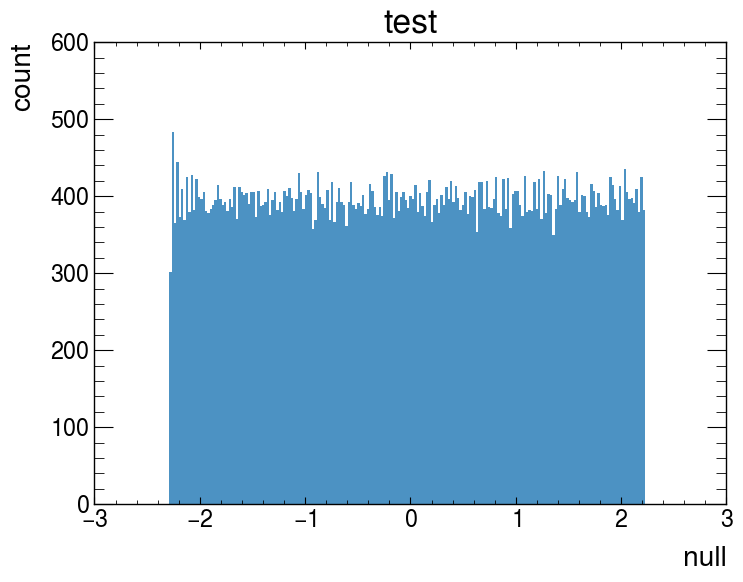

In [21]:
plt.hist(train_y, bins=200, alpha=.8)
plt.title(r"test")
plt.xlabel("null")
plt.ylabel("count")
# plt.xlim([0,0.5])
plt.show()

In [22]:
params = {
    "eval_metric": "rmse",
}
params, round_count = tune_xgb_model(
    params, train_x, train_y, nfold=num_folds, shuffle=True
)

tuning pass 0...
computing best round...
best round: 32
tuning max_depth and min_child_weight ...
best loss: 1.0361
best max_depth: 8
best min_child_weight: 3
tuning gamma ...
best loss: 1.0361
best gamma: 0.0
re-computing best round...
best round: 32
tuning subsample and colsample_bytree ...
best loss: 1.0361
best subsample: 1.0
best colsample_bytree: 1.0
fine tuning subsample and colsample_bytree ...
best loss: 1.0361
best subsample: 1.0
best colsample_bytree: 1.0
tuning alpha and lambda ...
best loss: 1.0359
best alpha: 1
best lambda: 1.1
tuning seed ...
best loss: 1.0359
best seed: 0
{'eval_metric': 'rmse', 'max_depth': 8, 'min_child_weight': 3, 'gamma': 0.0, 'subsample': 1.0, 'colsample_bytree': 1.0, 'alpha': 1, 'lambda': 1.1, 'seed': 0}
tuning pass 1...
computing best round...
best round: 24
tuning max_depth and min_child_weight ...
best loss: 1.0589
best max_depth: 8
best min_child_weight: 3
tuning gamma ...
best loss: 1.058
best gamma: 0.2
re-computing best round...
best round:

In [23]:
# Fit the results

model = XGBRegressor(**params)
model.fit(train_x, train_y)
pred_y = model.predict(test_x)

sig_pred = pred_y
sig_truth = test_y

In [27]:
len(sig_truth)

19800

In [24]:
sig_truth

array([[-2.22193646],
       [-0.97407326],
       [-0.9163183 ],
       ...,
       [ 0.26357685],
       [-0.92895272],
       [ 0.83472872]])

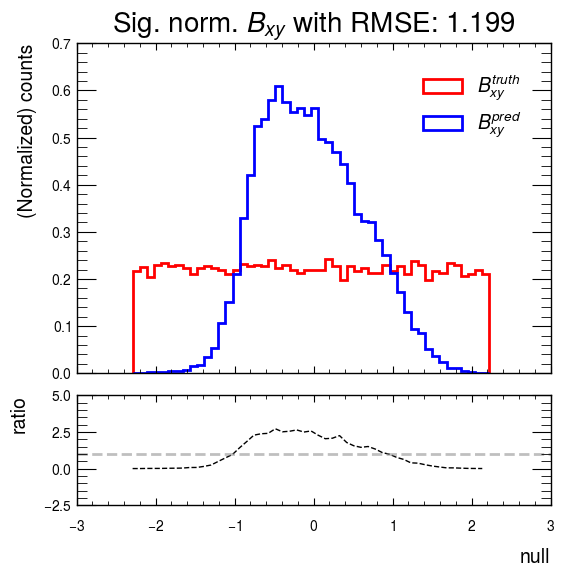

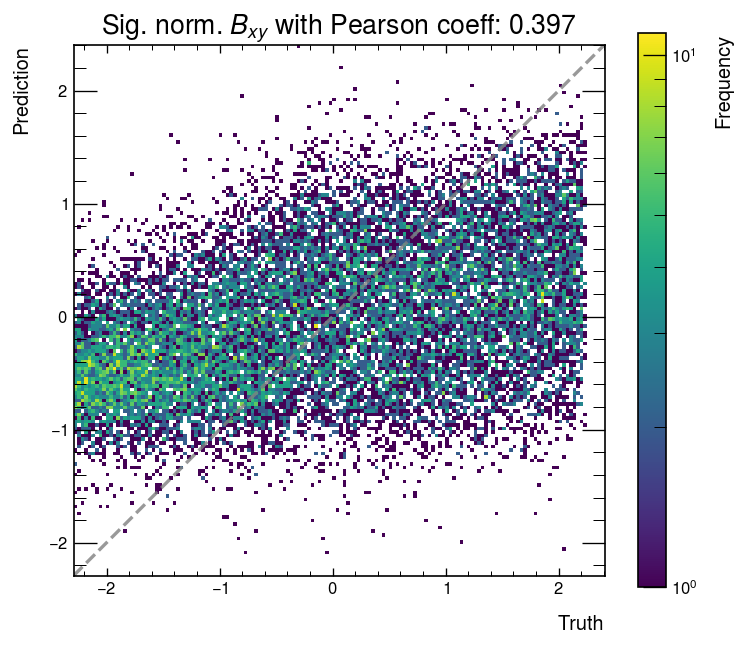

In [25]:
from sklearn.metrics import mean_squared_error

# range = [-1.3, 2.4]

plot.plot_hist(
    [sig_truth.flatten(), sig_pred.flatten()],
    [r"$B_{xy}^{truth}$", r"$B_{xy}^{pred}$"],
    r"Sig. norm. $B_{xy}$"
    + f" with RMSE: {np.sqrt(mean_squared_error(sig_truth.flatten(), sig_pred.flatten())):.3f}",
    # range=range,
    xlabel=r"null",
)

plot.plot_2d_histogram(
    sig_truth.flatten(),
    sig_pred.flatten(),
    r"Sig. norm. $B_{xy}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth.flatten(), sig_pred.flatten())[0]:.3f}",
    # range=range,
)

In [26]:
range = [-3, 3]

plot.plot_hist(
    [sig_truth[:, 1], sig_pred[:, 1]],
    [r"$p_{z\ truth}^{\nu\nu}$", r"$p_{z\ pred}^{\nu\nu}$"],
    r"Signal: Normalized $p_{z}$ of $\nu\nu$",
    range=range,
    xlabel=r"$p_{z}$ [GeV]",
)

plot.plot_2d_histogram(
    sig_truth[:, 1],
    sig_pred[:, 1],
    r"Signal: $p_{z}^{\nu\nu}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth[:,1], sig_pred[:,1])[0]:.3f}",
    range=range,
)

IndexError: index 1 is out of bounds for axis 1 with size 1

In [ ]:
# Background
processor = gd.DataProcessor(sampling=sampling, processor=10)
path = "/root/data/truth/background/*npz"
processor.load_files(path)
data = gd.Data(*processor.files)
# print(dir(data))

Number of available processors: 128
Number of used processors: 10

['/root/data/truth/background/CGLMP.npz', '/root/data/truth/background/Higgs.npz', '/root/data/truth/background/LeadLepton.npz', '/root/data/truth/background/LeptonM.npz', '/root/data/truth/background/LeptonP.npz', '/root/data/truth/background/LmNu.npz', '/root/data/truth/background/LpNu.npz', '/root/data/truth/background/MET.npz', '/root/data/truth/background/WmBoson.npz', '/root/data/truth/background/WpBoson.npz', '/root/data/truth/background/diLepton.npz', '/root/data/truth/background/subLeadLepton.npz', '/root/data/truth/background/xi_xyz.npz']



In [ ]:
# inputs -> observed params
lep_p = processor.process_part(data.LepP)[cut_pre]
lep_m = processor.process_part(data.LepM)[cut_pre]
lep_kin = pd.concat([lep_p, lep_m], axis=1)
MET = processor.process_MET(data.MET).iloc[:, 1:3][cut_pre]
obs_kin = pd.concat([MET, lep_kin], axis=1)
print("obs_kin shape:", obs_kin.shape)
print(obs_kin.head(3))
print()

# targets -> interested unknowns
int_kin = pd.DataFrame(
    processor.process_dipart(data.NuP, data.NuM)[["E", "pz"]][cut_pre]
)
print("int_kin shape:", int_kin.shape)
print(int_kin.head(3))
print()

del (processor, lep_p, lep_m, MET)
gc.collect()

obs_kin shape: (47089, 10)
      MET_px     MET_py          E         px         py         pz  \
2  12.542417  29.573581  47.815059 -21.315428  45.633828  -9.166943   
3 -28.046018 -45.255130  43.335184  30.948270 -12.014405 -59.042395   
4  -6.118746 -43.808047  31.977082  41.501539 -72.848164  65.469578   

            E         px         py          pz  
2   17.210883  20.278842  -5.134687   48.637703  
3  181.251000  -5.289632  10.576978 -406.692406  
4   30.541406 -21.632902 -12.714723  -71.628742  

int_kin shape: (47089, 2)
            E          pz
2  132.413469  198.908207
3  158.960164 -964.140969
4  177.617395   55.172611



41805

In [ ]:
SCALAR_int_bkg = StandardScaler()
int_kin = SCALAR_int.fit_transform(int_kin)

SCALAR_obs_bkg = StandardScaler()
obs_kin = SCALAR_obs.fit_transform(obs_kin)

x, y = obs_kin[indices_arr], int_kin[indices_arr]

print(f"X:\ndata shape: {x.shape};\nY:\ndata shape: {y.shape}.")
print()

X:
data shape: (47089, 10);
Y:
data shape: (47089, 2).



In [ ]:
y_pred = model.predict(x)
bkg_pred = y_pred
bkg_truth = y

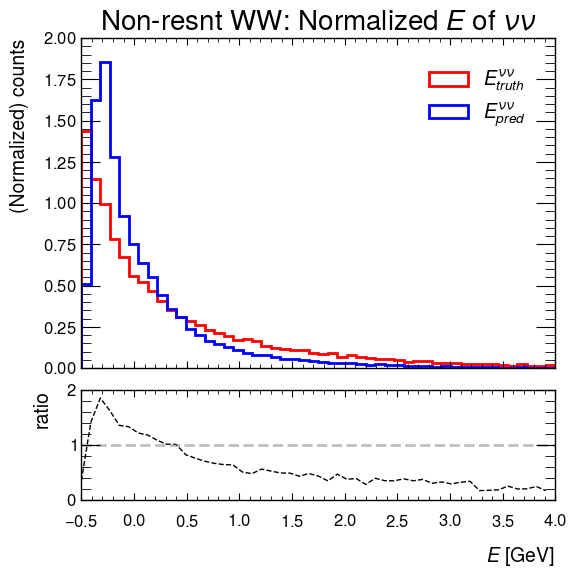

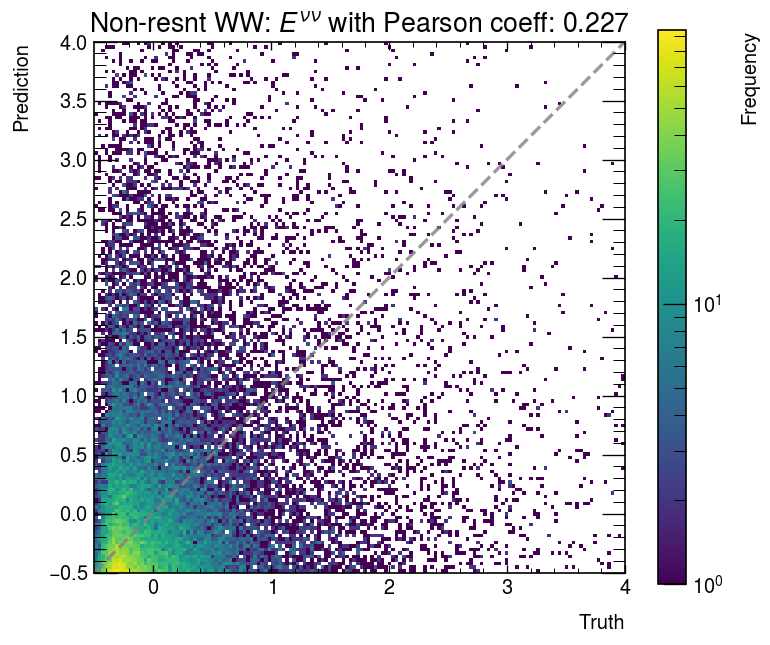

In [ ]:
range = [-0.5, 4]

plot.plot_hist(
    [bkg_truth[:, 0], bkg_pred[:, 0]],
    [r"$E_{truth}^{\nu\nu}$", r"$E_{pred}^{\nu\nu}$"],
    "Non-resnt WW: " + r"Normalized $E$ of $\nu\nu$",
    range=range,
    xlabel=r"$E$ [GeV]",
)

plot.plot_2d_histogram(
    bkg_pred[:, 0],
    bkg_truth[:, 0],
    "Non-resnt WW: "
    + r"$E^{\nu\nu}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(bkg_truth[:,0], bkg_pred[:,0])[0]:.3f}",
    range=range,
)

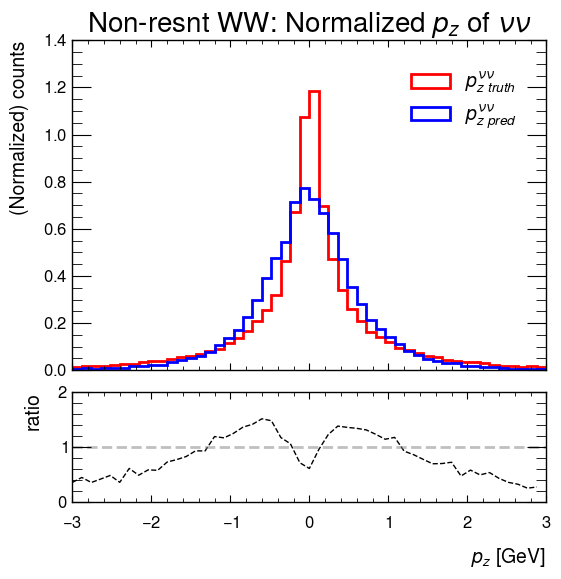

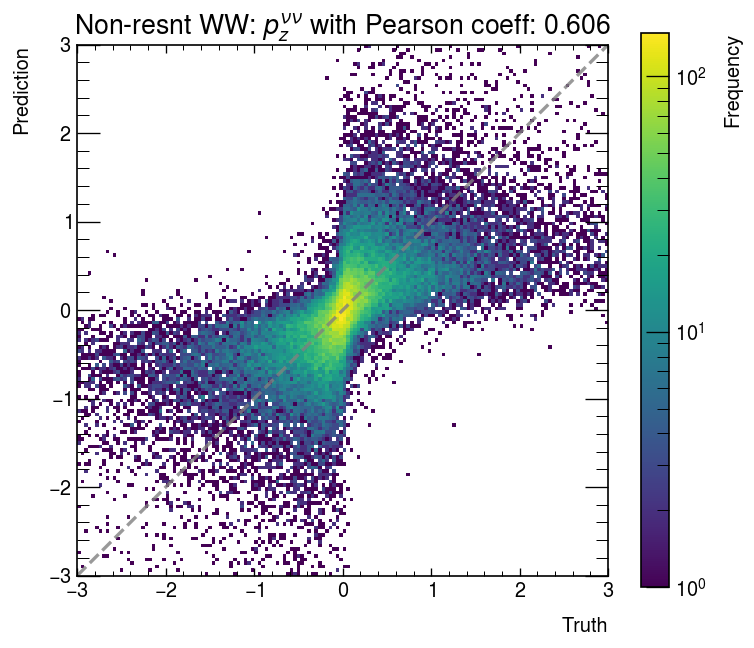

Time cost: 2103.72 s.


In [ ]:
range = [-3, 3]

plot.plot_hist(
    [bkg_truth[:, 1], bkg_pred[:, 1]],
    [r"$p_{z\ truth}^{\nu\nu}$", r"$p_{z\ pred}^{\nu\nu}$"],
    r"Non-resnt WW: Normalized $p_{z}$ of $\nu\nu$",
    range=range,
    xlabel=r"$p_{z}$ [GeV]",
)

plot.plot_2d_histogram(
    bkg_truth[:, 1],
    bkg_pred[:, 1],
    "Non-resnt WW: "
    + r"$p_{z}^{\nu\nu}$"
    + f" with Pearson coeff: {sp.stats.pearsonr(bkg_truth[:,1], bkg_pred[:,1])[0]:.3f}",
    range=range,
)

time_end = time()
print(f"Time cost: {(time_end - time_start):.2f} s.")